In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Load in the datasets
df_train = pd.read_csv('../data/train.csv')
df_oil = pd.read_csv('../data/oil.csv')
df_holidays_events = pd.read_csv('../data/holidays_events.csv')
df_stores = pd.read_csv('../data/stores.csv')
df_transactions = pd.read_csv('../data/transactions.csv')
# df_test = pd.read_csv('../data/test.csv')

df_train['date'] = pd.to_datetime(df_train['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])

dataframes = {
    'Training dataset': df_train,
    'Oil price dataset' :df_oil,
    'Holidays and events dataset': df_holidays_events,
    'Stores dataset': df_stores,
    'Transactions dataset': df_transactions
}

In [4]:
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False) 

In [5]:
terremoto_dates = df_holidays_events[df_holidays_events['description'].str.contains('Terremoto Manabi', case=False, na=False)]['date']
terremoto_sales = df_train[df_train['date'].isin(terremoto_dates)]
non_terremoto_sales = df_train[~df_train['date'].isin(terremoto_dates)]
non_terremoto_sales.sort_values(by='sales', ascending=False).head(1)

,id,date,store_nbr,family,sales,onpromotion
2445984,2445984,2016-10-07,39,MEATS,89576.360,0


In [10]:


# Step 1: Extract all dates for 'Cantonizacion de Quevedo' in df_holidays_events
event_dates = df_holidays_events[df_holidays_events['description'] == 'Cantonizacion de Quevedo']['date']

# Initialize an empty DataFrame to collect the results
meats_sales_all_events = pd.DataFrame()

# Step 2: Loop over all event dates, create a date range, and filter df_train
for event_date in event_dates:
    start_date = pd.to_datetime(event_date) - pd.Timedelta(days=7)
    end_date = pd.to_datetime(event_date) + pd.Timedelta(days=7)
    
    # Filter df_train for 'MEATS' sales within the date range
    meats_sales = df_train[(df_train['family'] == 'MEATS') & 
                           (df_train['date'] >= start_date) & 
                           (df_train['date'] <= end_date)]
    
    # Append the results to the final DataFrame
    meats_sales_all_events = pd.concat([meats_sales_all_events, meats_sales])

# Step 3: Display the collected sales data
# meats_sales_all_events.reset_index(drop=True, inplace=True)
meats_sales_all_events.sort_values(by='sales', ascending=False).head()


,id,date,store_nbr,family,sales,onpromotion
2445984,2445984,2016-10-07,39,MEATS,89576.360,0
2455719,2455719,2016-10-13,12,MEATS,11609.557,17
490569,490569,2013-10-03,23,MEATS,3767.584,0
503043,503043,2013-10-10,23,MEATS,2749.505,0
501261,501261,2013-10-09,23,MEATS,2524.521,0


C:\Users\ander\AppData\Local\Temp\ipykernel_21700\105538806.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


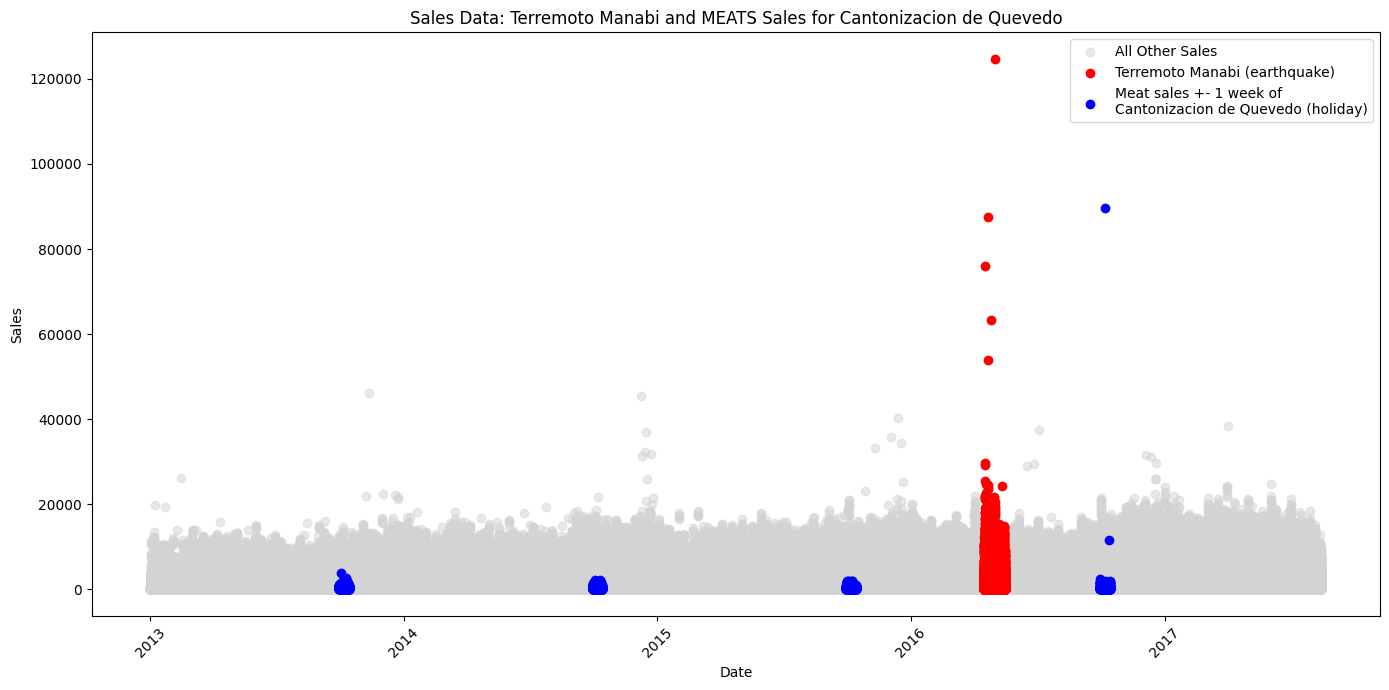

In [20]:
plt.figure(figsize=(14, 7))

# Step 2: Plot all sales data points
plt.scatter(df_train['date'], df_train['sales'], label='All Other Sales', color='lightgray', alpha=0.5)

# Step 3: Plot Terremoto Manabi entries
plt.scatter(terremoto_sales['date'], terremoto_sales['sales'], label='Terremoto Manabi (earthquake)', color='red', alpha=1)

# Step 4: Plot MEATS sales for Cantonizacion de Quevedo
plt.scatter(meats_sales_all_events['date'], meats_sales_all_events['sales'], label='Meat sales +- 1 week of\nCantonizacion de Quevedo (holiday)', color='blue', alpha=1)

# Step 5: Customize the plot
plt.title('Sales Data: Terremoto Manabi and MEATS Sales for Cantonizacion de Quevedo')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Step 6: Show the plot
plt.show()

In [26]:
plt.figure(figsize=(14, 7))

# Step 2: Plot all sales data points
plt.scatter(df_train['date'], df_train['sales'], label='All Other Sales', color='lightgray', alpha=0.5)

# Step 3: Plot Terremoto Manabi entries
terremoto_grocery_1 = terremoto_sales[terremoto_sales['family'] == 'GROCERY I']
plt.scatter(terremoto_grocery_1['date'], terremoto_grocery_1['sales'], label='Event: Terremoto Manabi (earthquake)\nFamily: GROCERY 1', color='red', alpha=1)

terremoto_beverages = terremoto_sales[terremoto_sales['family'] == 'BEVERAGES']
plt.scatter(terremoto_beverages['date'], terremoto_beverages['sales'], label='Event: Terremoto Manabi (earthquake)\nFamily: BEVERAGES', color='green', alpha=1)

# Step 4: Plot MEATS sales for Cantonizacion de Quevedo
plt.scatter(meats_sales_all_events['date'], meats_sales_all_events['sales'], label='Event: +- 1 week of Cantonizacion de Quevedo (holiday)\Family: MEATS', color='blue', alpha=1)

# Step 5: Customize the plot
plt.title('Sales Data: Terremoto Manabi and MEATS Sales for Cantonizacion de Quevedo')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Step 6: Show the plot
plt.show()

C:\Users\ander\AppData\Local\Temp\ipykernel_21700\2769561260.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


In [16]:
combined_sales = pd.concat([terremoto_sales, meats_sales_all_events])

# Create a DataFrame with all entries from df_train that are not in combined_sales
non_selected_sales = df_train[~df_train.index.isin(combined_sales.index)]

# Sort non_selected_sales by 'sales' in descending order and select the top 100 entries
top_100_non_selected = non_selected_sales.sort_values(by='sales', ascending=False).head(100)

# Find unique 'family' categories among the top 100
unique_families = top_100_non_selected['family'].unique()

# Convert to a list if you prefer
unique_families_list = unique_families.tolist()

top_100_non_selected.head(n=10)


,id,date,store_nbr,family,sales,onpromotion
562596,562596,2013-11-12,44,GROCERY I,46271.000,0
1257246,1257246,2014-12-08,35,GROCERY I,45361.000,3
1916586,1916586,2015-12-14,35,GROCERY I,40351.460,7
2760297,2760297,2017-04-02,9,GROCERY I,38422.625,73
2276022,2276022,2016-07-04,20,GROCERY I,37514.926,40
1271832,1271832,2014-12-16,44,GROCERY I,37106.000,7
1898370,1898370,2015-12-04,24,GROCERY I,35828.000,28
1923384,1923384,2015-12-18,26,GROCERY I,34454.000,14
1857219,1857219,2015-11-11,2,GROCERY I,33274.000,23
1269390,1269390,2014-12-15,26,GROCERY I,32209.000,17


C:\Users\ander\AppData\Local\Temp\ipykernel_16832\909190278.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


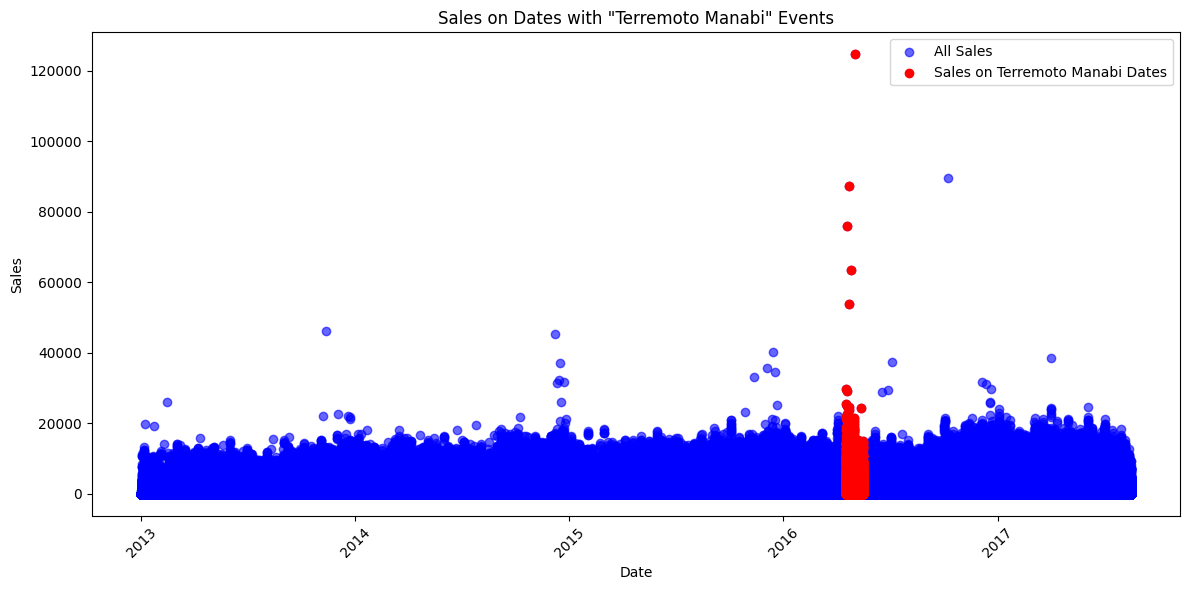

In [9]:
# Plot the sales data for the filtered dates
plt.figure(figsize=(12, 6))
plt.scatter(df_train['date'], df_train['sales'], color='blue', label='All Sales', alpha=0.6)
plt.scatter(terremoto_sales['date'], terremoto_sales['sales'], color='red', label='Sales on Terremoto Manabi Dates')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales on Dates with "Terremoto Manabi" Events')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_train[df_train['family'] == 'MEATS'].sort_values(by='sales', ascending=False).head()

In [ ]:
# Check for column existence before dropping
columns_to_drop = ['id', 'store_nbr', 'onpromotion']
df_train_filtered = df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns])

# Group by 'date' and 'family', summing the numeric columns
df = df_train_filtered.groupby(['date', 'family']).sum().reset_index()

df = df.sort_values(by='sales', ascending=False)

# Plot showing which families have the most sales
plt.figure(figsize=(14, 7))
family_sales = df.groupby('family')['sales'].sum().sort_values(ascending=False)
family_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales by Family')
plt.xlabel('Family')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Task 1. Data Exploration

## a. Explore the dataset by displaying the first few rows, summary statistics, and data types of each column.

### Display the first 5 rows
**Har valgt å ta de separat fordi det virker som at data clean kommer før integration**

In [ ]:
for name, df in dataframes.items():
    display(HTML(f"<h3 style='color: black;'>{name}</h3>"))
    display(df.head())

### Display the summary statistics for numerical columns

In [ ]:
for name, df in dataframes.items():
    display(HTML(f"<h3 style='color: black;'>{name}</h3>"))
    display(df.describe())

### Display the data type of each column

In [ ]:
for name, df in dataframes.items():
    display(HTML(f"<h3 style='color: black;'>{name}</h3>"))
    display(df.dtypes)

## b. Identify missing values, outliers, and unique values in categorical columns.

### Identify missing values

In [ ]:
for name, df in dataframes.items():
    display(HTML(f"<h3 style='color: black;'>{name}</h3>"))
    display(df.isnull().sum())

### Identify for outliers
Har bare plottet opp scatterplot av numerisk data som funksjon av tid, basert på det rent visuelle ser man at det er enkelte registreringer som er forholdsvis langt unna andre registrerringer, som kan tyde på at de muligens kan være outliers. Dette undersøkes nærmere i punkt 3 for "handling outliers".

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(x=df_train['date'], y=df_train['sales'], label='Sales', marker='o', s=10)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales by date')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(x=df_train['date'], y=df_train['onpromotion'], label='Promotion', marker='o', s=10)
plt.xlabel('Date')
plt.ylabel('Promotion')
plt.title('Promotion by date')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(x=df_oil['date'], y=df_oil['dcoilwtico'], label='oil price', marker='o', s=10)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Oil price by date')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(x=df_transactions['date'], y=df_transactions['transactions'], label='Transactions', marker='o', s=10)
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.title('Transactions by date')
plt.legend()
plt.show()

### Check for unique values in categorical columns

In [ ]:
for name, df in dataframes.items():
    display(HTML(f"<h3 style='color: black;'>{name}</h3>"))
    columns_to_display = list(df.select_dtypes(include=["object"]).columns) 
    if 'store_nbr' in df:
        columns_to_display.append('store_nbr')
    columns_to_display = [column for column in columns_to_display if column != 'date']
    display(
        HTML(
            pd.DataFrame(
                [
                    {
                        "Column Name": column,
                        "Unique Values": ", ".join(map(str, df[column].unique())),
                    }
                    for column in columns_to_display
                ]
            ).to_html(index=False)
        )
    )

# Task 2. Data Cleaning

## a. Handling Missing Values
## b. Choose appropriate methods to handle missing values (e.g., mean/median imputation for numerical data, mode imputation for categorical data, or deletion of rows/columns).

Det er kun oil price som har missing values, og den har kun 1219 rader. 
Dette går nok innunder kategorien 'lite datasett', og man kan dermed ikke bare fjerne radene med manglende verdier. Dette kommer til å fjerne 5% av datasettet. 

Da blir det "imputation", narurlig med mean eller median. [Denne](https://www.kaggle.com/code/pagenotfound/mean-and-median-imputation) artikkelen sier at mean brukes når fordelingen er normalfordelt, eller median. Basert på histogrammet er det tydelig at fordelingen ikke er normalfordelt, så da blir det median. Det gir iidlertid denne utviklingen, som ikke ser helt realistisk ut:

In [ ]:
df_oil_copy = df_oil.copy()
median_value = df_oil_copy['dcoilwtico'].median()
original_dcoilwtico = df_oil_copy['dcoilwtico'].copy()
df_oil_copy['dcoilwtico'] = df_oil_copy['dcoilwtico'].fillna(median_value)
filled_mask = original_dcoilwtico.isnull()
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_oil_copy, x='date', y='dcoilwtico', color='blue', label='dcoilwtico', marker='', linestyle='-')
plt.scatter(df_oil_copy.loc[filled_mask, 'date'], 
    df_oil_copy.loc[filled_mask, 'dcoilwtico'], 
    color='red', label='Filled Values', s=50
)
plt.title('Time Series Plot of dcoilwtico with Filled Values Highlighted')
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
df_oil_copy = df_oil.copy()
original_dcoilwtico = df_oil_copy['dcoilwtico'].copy()
df_oil_copy['dcoilwtico'] = df_oil_copy['dcoilwtico'].ffill().interpolate().bfill()
filled_mask = original_dcoilwtico.isnull()
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_oil_copy, x='date', y='dcoilwtico', color='blue', label='dcoilwtico', marker='', linestyle='-')
plt.scatter(df_oil_copy.loc[filled_mask, 'date'], 
            df_oil_copy.loc[filled_mask, 'dcoilwtico'], 
            color='red', label='Filled Values', s=50)
plt.title('Time Series Plot of dcoilwtico with Filled Values Highlighted (Linear Interpolation)')
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# since it looks good, use this as df_oil
df_oil = df_oil_copy.copy()
df_oil.isnull().sum()

## c. Justify your choices for handling missing data.

Basert på timeseries'ene, så virker det svært lite realitsik at de verdiene vi erstatter faktisk er median-verdier, eller noe i nærheten. Ved å plott opp utfyllingen ved å heller bruke lineær itnerpolasjon, ser det ut til at de innfylte dataene passer mye bedre inn. 

# Task 3. Handling Outliers

## a. Detect outliers using methods such as the IQR method or Z-score.

Z-score baserer seg på å kvitte seg med verdier utenfor 3*standardavviket. Her burde dog dataen være notmalfordelt, og ikke være en tidsserie der dataen har en trend. Trenden kan gjøre at verdiene på starten/slutten blir tatt vekk fordi de er for ekstreme, når det egentlig bare skyldes at trenden har økt, og ikke at det er feilregistreringer. Dermed er den ikke bra her.

IQR trenger ikke nødvendigvis normalfordelt data, men som forklart her vil ikke dette fungere godt i dette tilfellet (som boxplot'et ogs viser):
I wouldn't use IQR nor Percentiles to detect outliers in a times series since these statistics are computed on the overall sample (at least how I understand it with your question) but you have some effects (dynamic/cyclic/trends) in time series. In fact, if your value grows over time (or is cyclical) you may detect outliers regarding previous values. [kilde fra forum](https://stats.stackexchange.com/questions/486466/a-robust-technique-to-detect-outliers-from-time-series-data)

I forelesningen ble det foreslått å bruke "sliding z-score" ellernoe for timeseries, har plottet opp den under. Greia her er dog at for at verdiene skal bli klassifisert som outliers, så burde det ikke være noen legitim grunn til at det er så ekstreme. Men om man sammenlikner med holidays og events og ser foreksempel at det var et rekordstort jordskjelv rett før sales økte noe voldsomt, så er det plutselig en grunn til at sales har økt, og det blir rart å klassifisere de som outliers (siden de er ekstreme av en grunn).

Foreslår dermed å ikke klassifisere noen verdier som outliers, siden ingen av verdiene er ekstreme av overraskende grunner.

In [ ]:
# Hvorfor z-score ikke fungerer
# Calculate mean and standard deviation
mean_sales = df_train['sales'].mean()
std_sales = df_train['sales'].std()

# Calculate upper and lower bounds for Z-score outlier detection
z_threshold = 3
upper_bound = mean_sales + (z_threshold * std_sales)
lower_bound = mean_sales - (z_threshold * std_sales)

# Create a plot with only scatter
plt.figure(figsize=(14, 7))

# Scatter plot of sales
plt.scatter(df_train['date'], df_train['sales'], color='blue', alpha=0.6)

# Add horizontal lines for upper and lower bounds
plt.axhline(upper_bound, color='red', linestyle='--', label='Upper Bound (Z=3)')
plt.axhline(lower_bound, color='red', linestyle='--', label='Lower Bound (Z=-3)')

# Highlight the outliers
outliers = df_train[(df_train['sales'] > upper_bound) | (df_train['sales'] < lower_bound)]
plt.scatter(outliers['date'], outliers['sales'], color='red', label='Outliers', zorder=5)

# Plot customization
plt.title('Sales Time Series with Z-score Outlier Detection Bands')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()
print((len(outliers) / len(df_train)) * 100)

In [ ]:
# Hvorfor IQR ikke fungerer
plt.boxplot(df_train['sales'])
plt.show()

In [ ]:
# Calculate the IQR bounds
q1 = df_train['sales'].quantile(0.25)
q3 = df_train['sales'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Plot the time series with the IQR bounds
plt.figure(figsize=(14, 7))
plt.plot(df_train.index, df_train['sales'], color='blue', label='Sales', alpha=0.6)

# Add horizontal lines for upper and lower bounds
plt.axhline(upper_bound, color='red', linestyle='--', label='Upper Bound (IQR)')
plt.axhline(lower_bound, color='red', linestyle='--', label='Lower Bound (IQR)')

# Highlight the outliers based on IQR
outliers = df_train[(df_train['sales'] > upper_bound) | (df_train['sales'] < lower_bound)]
plt.scatter(outliers.index, outliers['sales'], color='red', label='Outliers', zorder=5)

# Customize the plot
plt.title('Sales Time Series with IQR Outlier Detection')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Log transform og IQR
df_train_copy = df_train.copy()

if (df_train_copy['sales'] <= 0).any():
    print("Warning: Sales column contains zero or negative values, which cannot be log-transformed directly.")
    # Option 1: Filter out non-positive values
    df_train_copy = df_train_copy[df_train_copy['sales'] > 0].copy()
    # Option 2: Alternatively, add a small constant to avoid log(0) issues
    # df_train['sales'] = df_train['sales'] + 1e-9

# Step 2: Apply the log transformation to the 'sales' column
df_train_copy['log_sales'] = np.log(df_train_copy['sales'])

# Step 3: Plot the original sales data and the log-transformed data
plt.figure(figsize=(14, 7))

# Plot original sales data
plt.subplot(1, 2, 1)
plt.hist(df_train_copy['sales'], bins=50, color='blue', alpha=0.7)
plt.title('Original Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Plot log-transformed sales data
plt.subplot(1, 2, 2)
plt.hist(df_train_copy['log_sales'], bins=50, color='green', alpha=0.7)
plt.title('Log-Transformed Sales Distribution')
plt.xlabel('Log(Sales)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Q1 = df_train_copy['log_sales'].quantile(0.25)
Q3 = df_train_copy['log_sales'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 2: Identify outliers in the log-transformed data
df_train_copy['is_outlier'] = (df_train_copy['log_sales'] < lower_bound) | (df_train_copy['log_sales'] > upper_bound)

# Step 3: Filter out the outliers
df_train_filtered = df_train_copy[~df_train_copy['is_outlier']].copy()  # Keep only non-outliers

# Step 4: Plot the time series before and after outlier removal

# Plot sales data before outlier removal
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.scatter(df_train_copy['date'], df_train_copy['sales'], color='blue', label='Original Sales Data', alpha=0.6)
plt.scatter(df_train_copy[df_train_copy['is_outlier']]['date'], 
            df_train_copy[df_train_copy['is_outlier']]['sales'], 
            color='red', label='Outliers', alpha=0.8)
plt.title('Sales Time Series with Outliers (Before Removal)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Plot sales data after outlier removal
plt.subplot(2, 1, 2)
plt.scatter(df_train_filtered['date'], df_train_filtered['sales'], color='green', label='Sales Data After Outlier Removal', alpha=0.6)
plt.title('Sales Time Series After Outlier Removal')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

plt.tight_layout()
plt.show()

# Step 5: Review the number of outliers removed
print(f"Total Outliers Detected: {df_train_copy['is_outlier'].sum()}")
print(f"Remaining Data Points: {len(df_train_filtered)}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure the index is in datetime format if it's not already
df_train['date'] = pd.to_datetime(df_train['date'])  # Convert 'date' to datetime if needed
df_train.set_index('date', inplace=True)  # Set date as the index

# Group the sales by date (sum for each day)
daily_sales = df_train['sales'].groupby(df_train.index.date).mean()

# Check the total number of observations
print(f'Total observations in daily sales: {len(daily_sales)}')

# Ensure you have enough data points (at least 730 for period=365)
if len(daily_sales) >= 730:
    decomposition = seasonal_decompose(daily_sales, model='additive', period=365)
    
    # Access the trend component
    trend = decomposition.trend

    # Plot the trend component
    plt.figure(figsize=(16, 8))  # Increase the figure size
    plt.plot(trend, label='Trend', color='orange')
    plt.title('Trend for average total daily sales')
    plt.xlabel('Date')
    plt.ylabel('Average daily sales')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Not enough data for seasonal decomposition with a yearly period.")


In [ ]:
column = df_train['sales']
window_percentage = 3  # Adjustable as needed
k = int(len(column) * (window_percentage / 2 / 100))

# Step 2: Use rolling windows to calculate dynamic bands (optimized)
rolling_window = column.rolling(window=2*k, center=True, min_periods=1)
mean_rolling = rolling_window.mean()
std_rolling = rolling_window.std()

# Step 3: Calculate upper and lower bounds using quantile-based outlier detection
upper = mean_rolling + rolling_window.quantile(0.9)
lower = mean_rolling - rolling_window.quantile(0.98)

bands_df = pd.DataFrame({
    'upper': upper,
    'lower': lower
})
# bands_df.to_csv('../cache/bands.csv', index=False)

# bands_df = pd.read_csv('../cache/bands.csv')

# Step 5: Identify anomalies (sales values outside the bounds)
anomalies = (column > upper) | (column < lower)

# Step 6: Plot the sales data with detected anomalies and dynamic bounds
plt.figure(figsize=(20, 10))

# Plot the original sales data
plt.scatter(df_train['date'], column, color='blue', alpha=0.6)

# Plot the upper and lower bounds

# Highlight anomalies
plt.scatter(df_train['date'][anomalies], column[anomalies], color='orange', label='Outliers', zorder=5)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Outlier detection for sales using 98th percentile as threshold')
plt.legend()

plt.plot(df_train['date'], upper, color='green', label='Upper Bound (98th quantile)')
plt.plot(df_train['date'], lower, color='red', label='Lower Bound (98th quantile)')

# Display plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Sort the dataframe by sales in descending order
df_train_sorted = df_train.sort_values(by='sales', ascending=False)
df_train_sorted.head()

In [ ]:
categories = df_train_sorted['family'].unique()
sum_sales = df_train_sorted[df_train_sorted['family'].isin(categories)].groupby('family')['sales'].sum()
sum_sales = sum_sales.sort_values(ascending=False)
sum_sales.plot(kind='bar', figsize=(14, 7), color='skyblue')

In [ ]:
holiday_dates = df_holidays_events['date'].unique()
df_train_copy = df_train.copy()
df_train_copy['is_holiday'] = df_train_copy['date'].isin(holiday_dates)
plt.figure(figsize=(12, 6))
no_holiday_data = df_train_copy[df_train_copy['is_holiday'] == False]
plt.scatter(no_holiday_data['date'], no_holiday_data['sales'], color='blue', label='No Holiday')
holiday_data = df_train_copy[df_train_copy['is_holiday'] == True]
plt.scatter(holiday_data['date'], holiday_data['sales'], color='red', label='Holiday')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales vs Date (Holidays Highlighted)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## b. Decide whether to remove, cap, or transform the outliers. Justify your decisions.
Det står i README'en at (og man kan se i holidays_events.csv):
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

De store spikes'ene kommer akkuratt samtidig som jordskjelvet, som har hatt dokumentert påvirkning på supermarket sales. Ettersom disse "outlierne" da sannsynligvis er reelle, og ikke må skyldes feilregistreringer, så kan det også godt være at de andre, men mindre, "outlierne" som skjedde tidligere egentlige ikke er feilregistreringer, siden det faktisk er fullt mulig å få så høye verdier. De andre outlierne kommer jo oftest ved årsskifte, så det er neppe noen tilfeldighet. 

Ved å skrive litt om de mulige metodene for outlier detection, for så å peke på at "outlierne" her trolig er reelle, så tor jeg det er helt fint å ikke fjerne noen verdier her. 

# Data Transformation

## a. Encoding Categorical Data


### i. Apply label encoding or one-hot encoding to transform categorical data into numerical form.

In [5]:
df_train = pd.get_dummies(df_train, columns=['family', 'store_nbr']).astype(int)
df_train.head()

,id,date,sales,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,store_nbr_1,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
0,0,1356998400000000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1356998400000000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1356998400000000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1356998400000000000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,1356998400000000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### ii. Justify your choice of encoding method.

Her ble one-hot-encoding benyttet. Grunnen til dette er at label encoding erstatter kategori-navnene med tall, hvorav maskinlæringsmodeller kan tolke dette som rekkefølger/at noe er større enn noe annet. Foreksempel, hvis man bruker label encoding på family_AUTOMOTIVE og family_BABYCARE, hvor family_AUTOMOTIVE=1 og family_BABYCARE=2, så kan noen modeller oppfatte dette som at family_AUTOMOTIVE < family_BABYCARE, når det egentlig ikke er noen rekkefølge på det. Label encoding brukes derfor ofte når kategoriene har en bestemt rekkefølge, foreksempel og kategoriene er EASY, MEDIUM, HARD. 

One-hot-encoding derimot, setter opp en kolonne for hver av kategoriene, og putter en 1'er i den kolonnen man har en kategori. Dette forhindrer dermed at modeller kan tolke kategoriene som rekkefølger. One-hot brukes dermed når det ikke er noen rekkefølge på kategoriene, som er tilfellene her med family og store_nbr. 

## b. Feature Scaling

### i. Apply feature scaling techniques such as normalization (Min-Max scaling) or standardization (Z-score normalization) to the dataset
Gikk for normalization: [Kilde](https://www.shiksha.com/online-courses/articles/normalization-and-standardization/#8)

In [ ]:
columns_to_scale = ['date', 'sales', 'onpromotion']
min_max_scaler = MinMaxScaler()
df_train[columns_to_scale] = min_max_scaler.fit_transform(df_train[columns_to_scale])
df_train[(df_train['sales'] > 0) & (df_train['onpromotion'] > 0)].head()

### ii. Explain why feature scaling is necessary and how it impacts the model.

!!! chatgpt, må skrive dette med egne ord:

1. **Handling Different Ranges:**
   - Data features can vary greatly in their range of values. For example, one feature might range from 0 to 1000, while another might range from 0 to 1. This difference can cause issues in machine learning models that are sensitive to the scale of the input features (e.g., gradient-based models like linear regression or neural networks).
   
2. **Model Performance:**
   - **Gradient Descent-based models** (e.g., linear regression, neural networks) are highly sensitive to the scale of input data. If one feature dominates due to its large magnitude, it can cause the model to converge more slowly or get stuck in suboptimal solutions.
   - Models like **K-Nearest Neighbors (KNN)**, **Support Vector Machines (SVM)**, and **Principal Component Analysis (PCA)** rely on distances between data points. Without scaling, features with larger ranges can disproportionately influence the distances and, consequently, the model's performance.

3. **Improves Training Stability:**
   - In neural networks, if input features have different scales, the optimization process during backpropagation can be more unstable, leading to poor convergence and potentially exploding or vanishing gradients. Scaling helps stabilize training and improves convergence speed.

4. **Prevents Bias in Models:**
   - Without scaling, models might place more importance on features with larger ranges, which could result in biased models that don't perform well on unseen data. Feature scaling ensures each feature contributes equally to the model's predictions.


# 5. Data Splitting

## a. Split the preprocessed dataset into training and testing sets. Typically, an 80-20 or 70-30 split is used.

In [ ]:
target_variable = 'sales'

X = df_train.drop(target_variable, axis=1)
y = df_train[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## b. Explain the importance of splitting the data and how it prevents overfitting.

!!! Igjen, bare chatgpt her, men gode poeng, burde skrive dette med egne ord

##### Splitting the Preprocessed Dataset into Training and Testing Sets

When building a machine learning model, it is crucial to evaluate its performance on unseen data. To achieve this, the dataset is typically split into two subsets: the training set and the testing set. 

##### Common Splitting Ratios
- **80-20 Split:** This is one of the most common splits. 80% of the data is used for training the model, while 20% is reserved for testing. This ratio provides a good balance, allowing the model to learn from a substantial amount of data while still having enough data to evaluate its performance effectively.
- **70-30 Split:** In cases where the dataset is relatively small, a 70-30 split can also be effective. This allows for a larger testing set to better assess the model's performance and generalization capability.

##### Reasons for Choosing a Percentage
1. **Balance Between Training and Testing:**
   - The goal is to provide enough data for the model to learn from while ensuring that the testing set is large enough to provide a reliable estimate of the model's performance on unseen data.

2. **Avoiding Overfitting:**
   - Using a significant portion of the data for training (e.g., 80%) helps the model learn complex patterns. However, keeping a substantial portion (e.g., 20%) for testing helps detect overfitting, where the model performs well on training data but poorly on unseen data.

3. **Generalizability:**
   - A proper split helps ensure that the model can generalize well to new, unseen data, which is essential for practical applications. A too-small testing set might lead to unreliable performance metrics.

4. **Domain-Specific Considerations:**
   - Depending on the application, the importance of training versus testing data might vary. For example, in some cases (e.g., medical or financial applications), it's more critical to have a robust testing set to evaluate the model's reliability.


# 6. Bonus Task (dimentionality reduction): Apply dimensionality reduction techniques such as Principal Component Analysis (PCA) and discuss how it affects the dataset.

!!! chatgpt

### Dimensionality Reduction: An Overview

Dimensionality reduction is the process of reducing the number of features or variables in a dataset while retaining essential information. This technique is beneficial for several reasons:

1. **Reduced Complexity:** By decreasing the number of dimensions, models can become less complex and easier to interpret.
2. **Improved Performance:** It can enhance the performance of machine learning algorithms by reducing overfitting and speeding up computation times.
3. **Enhanced Visualization:** Lower-dimensional data can be visualized more easily, allowing for better insights into the structure and patterns within the data.

### Why PCA?

Principal Component Analysis (PCA) is a popular dimensionality reduction technique due to its effectiveness in:

- **Variance Preservation:** PCA selects principal components that capture the most variance in the data, ensuring that the important features are retained.
- **Uncorrelated Components:** The new features generated by PCA are uncorrelated, which helps in avoiding multicollinearity issues.
- **Computational Efficiency:** PCA is computationally efficient and can handle large datasets effectively, making it suitable for various applications in data analysis and machine learning.


In [ ]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
print(f'Original number of features: {X_train.shape[1]}')
print(f'Reduced number of features: {X_train_pca.shape[1]}')